## Homework 6
This notebook contains the solutions for the fifth homework assignment of the Machine Learning Zoomcamp 2025 course, which can be viewed on github with the following [link](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2025/06-trees/homework.md). The final solutions notebook is submitted for grading at the following [link](https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw06).
### Setup

In [50]:
# Import packages
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
# from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split
# from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [16]:
# Load the dataset from the following url
url_path = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
target_col="fuel_efficiency_mpg"
# Prepend this string to final answers so they print as bold text
BOLD = "\033[1m"

In [17]:
# Load data and inspect it
cfe_df = pd.read_csv(url_path)
cfe_df.info()
cfe_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   num_cylinders        9222 non-null   float64
 2   horsepower           8996 non-null   float64
 3   vehicle_weight       9704 non-null   float64
 4   acceleration         8774 non-null   float64
 5   model_year           9704 non-null   int64  
 6   origin               9704 non-null   object 
 7   fuel_type            9704 non-null   object 
 8   drivetrain           9704 non-null   object 
 9   num_doors            9202 non-null   float64
 10  fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 834.1+ KB


,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369
5,190,3.0,NaN,2484.883986,14.7,2008,Europe,Gasoline,All-wheel drive,-1.0,17.271818
6,240,7.0,127.0,3006.542287,22.2,2012,USA,Gasoline,Front-wheel drive,1.0,13.210412
7,150,4.0,239.0,3638.657780,17.3,2020,USA,Diesel,All-wheel drive,1.0,12.848884
8,250,1.0,174.0,2714.219310,10.3,2016,Asia,Diesel,Front-wheel drive,-1.0,16.823554
9,150,4.0,123.0,3509.036569,10.2,2005,USA,Gasoline,Front-wheel drive,-1.0,12.298355


#### Preprocessing

In [18]:
# Replace missing values in 'annual_income column with zeros
categorical_cols = list(cfe_df.dtypes[cfe_df.dtypes == "object"].index)
numeric_cols = [cn for cn in cfe_df.columns if cn not in categorical_cols and cn != target_col]
print(f"Categorical columns = {categorical_cols}\n")
print(f"Numerical columns = {numeric_cols}\n")
cfe_df[numeric_cols] = cfe_df[numeric_cols].fillna(0)
cfe_df.info()

Categorical columns = ['origin', 'fuel_type', 'drivetrain']

Numerical columns = ['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight', 'acceleration', 'model_year', 'num_doors']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   num_cylinders        9704 non-null   float64
 2   horsepower           9704 non-null   float64
 3   vehicle_weight       9704 non-null   float64
 4   acceleration         9704 non-null   float64
 5   model_year           9704 non-null   int64  
 6   origin               9704 non-null   object 
 7   fuel_type            9704 non-null   object 
 8   drivetrain           9704 non-null   object 
 9   num_doors            9704 non-null   float64
 10  fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(6), int64(2), object(3)
memor

#### EDA
The target variable is reasonably balanced with about 62% positive and 38% negative.

In [19]:
cfe_df[target_col].value_counts(dropna=False, normalize=True)

fuel_efficiency_mpg
13.231729    0.000103
13.688217    0.000103
14.246341    0.000103
16.912736    0.000103
12.488369    0.000103
               ...   
15.101802    0.000103
17.962326    0.000103
17.186587    0.000103
15.331551    0.000103
14.884467    0.000103
Name: proportion, Length: 9704, dtype: float64

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

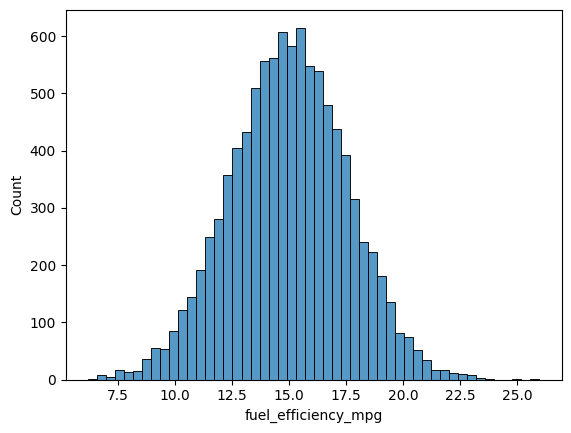

In [20]:
sns.histplot(cfe_df[target_col], bins=50)

#### Define functions

In [29]:
# Split the dataset
def split_train_val_test(df, val_ratio=.2, test_ratio=.2, r_seed=1, verbose=False):
    """Use the train_test_split function from sklearn to split input dataframe
    into randomly shuffled train, validation, and test datasets with the
    validation dataset containing val_ratio of the input data and the test
    dataset containing test_ratio of the input data.
    """
    n = len(df)
    # Generate test dataset
    full_train_df, test_df = train_test_split(df, test_size=test_ratio, random_state=r_seed)
    test_df = test_df.reset_index(drop=True)
    # Generate train, validation, and test splits
    val_ft_ratio = val_ratio / (1 - test_ratio)
    train_df, val_df = train_test_split(full_train_df, test_size=val_ft_ratio, random_state=r_seed)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    if verbose:
        print(f"All rows in the original dataframe are contained within the training, validation, or test datasets: {len(train_df) + len(val_df) + len(test_df) == len(df)}")
    return train_df, val_df, test_df

def split_full_train_test(df, test_ratio=.2, r_seed=1, verbose=False):
    """Use the train_test_split function from sklearn to split input dataframe
    into randomly shuffled train, validation, and test datasets with the
    validation dataset containing val_ratio of the input data and the test
    dataset containing test_ratio of the input data.
    """
    n = len(df)
    # Generate test dataset
    full_train_df, test_df = train_test_split(df, test_size=test_ratio, random_state=r_seed)
    test_df = test_df.reset_index(drop=True)
    full_train_df = full_train_df.reset_index(drop=True)
    if verbose:
        print(f"All rows in the original dataframe are contained within the training, validation, or test datasets: {len(full_train_df) + len(test_df) == len(df)}")
    return full_train_df, test_df
    
# Prepare X and y
def prepare_X_y(df_list, target_col, scale_num_cols=False, verbose=False, labels=[" training "]):
    """Create target vector, y, and feature matrix, X, from input list of
    dataframes, df_list. Use one-hot encoding to transform categorical variables.
    A training dataframe must be input to train the encoders and it must
    correspond to a label in the input list, labels, that contains the word
    "train". Numerical columns are scaled using the StandardScaler if the
    parameter, scale_num_cols, contains a list of numeric columns. The
    validation and test dataframes are optional and they will be encoded based
    on a fit to the training dataframe.
    """
    X_list = []
    y_list = []
    for ind, df in enumerate(df_list):
        # print(ind, df)
        df = df.copy()
        y_tmp = df[target_col].values
        tmp_dicts = df.drop(columns=target_col).to_dict(orient="records")
        if "training" in labels[ind]:
            dv = DictVectorizer(sparse=True)
            X_tmp = dv.fit_transform(tmp_dicts)
            X_names = dv.get_feature_names_out().astype(str)
            if scale_num_cols:
                X_num_cols = np.isin(X_names, scale_num_cols)
                scaler = StandardScaler()
                X_tmp[:, X_num_cols] = scaler.fit_transform(X_tmp[:, X_num_cols])
        else:
            X_tmp = dv.transform(tmp_dicts)
            if scale_num_cols:
                X_tmp[:, X_num_cols] = scaler.fit_transform(X_tmp[:, X_num_cols])
        if verbose:
            if len(labels) != len(df_list):
                labels = labels * len(df_list)
            print(f"All {len(df)} rows in the{labels[ind]}dataframe are contained within X and y: {len(X_tmp) == len(y_tmp) == len(df)}\n")
        X_list.append(X_tmp)
        y_list.append(y_tmp)
    return X_list, y_list, X_names




### Split the data into train, validation, and test datasets
1. Split the data in train/val/test sets with 60%/20%/20% distribution
2. Use Scikit-Learn for splitting (the train_test_split function) and set the seed to 1

Make sure that the target value y is not in your dataframe.

In [30]:
train_df, val_df, test_df = split_train_val_test(cfe_df, verbose=True)

All rows in the original dataframe are contained within the training, validation, or test datasets: True


### Q1. Decision tree feature importance
Train a decision tree regressor to predict the `fuel_efficiency_mpg` variable with `max_depth=1`.

Which feature is used for splitting the data?

In [32]:
(X_train, X_val), (y_train, y_val), X_names = prepare_X_y([train_df, val_df], target_col=target_col, verbose=False, labels=[" training ", " validation "])

In [51]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=X_names))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



In [54]:
print(f"The feature used for spliiting is {BOLD}{X_names[dt.feature_importances_==1][0]}")

The feature used for spliiting is vehicle_weight


### Q2. Random forest RMSE
Train a random forest regressor with these parameters:
1. `n_estimators=10`
2. `random_state=1`
3. `n_jobs=-1` (optional - to make training faster)

What's the RMSE of this model on the validation data?

In [12]:
print(f"{BOLD}{None}")

None


### Q3. Best `n_estimators` parameter

Experiment with the `n_estimators` parameter:
1. Try different values of this parameter from 10 to 200 with step 10.
2. Set random_state to 1.
3. Evaluate the model on the validation dataset.
4. Consider 3 decimal places for calculating the answer
5. If it doesn't stop improving, use the latest iteration number in your answer

After which value of `n_estimators` does RMSE stop improving?

In [ ]:
print(f"{BOLD}{None}")

### Q4.

In [9]:
print(f"{BOLD}{None}")

None


### Q5. 

In [10]:
print(f" {BOLD}{None}")

 None


### Q6. 

In [11]:
print(f"{BOLD}{None}")

None


### Extra Credit